In [1]:
import gymnasium as gym
import RL_Agent
from RL_Agent import nimAgent
import lab7lib as lab7
import numpy as np

In [2]:
#Registers the custom Nim environment/class annd saves it with an identifier
gym.envs.registration.register(
     id='nim-v0',
     entry_point='gym_nim.envs:NimEnv',
 )

In [3]:
#Creates the environment
nim = gym.make("nim-v0")

In [4]:
#Resets the environment and checks to see the current observation space
observation, info = nim.reset()
observation

15

In [5]:
#Checks the action space
nim.action_space.n

3

In [6]:
#Gets a sample action from the avaliable moves
action = nim.action_space.sample()
action

1

In [7]:
# Checks what step returns when the action is '2'
nim.step(2)

(12, 0.08000000000000002, False, False, {})

In [8]:
#An additional env for visulizing the agent (used for testing)
display = gym.make("nim-v0")
display.reset()

(15, {})

In [9]:
#First training, primarily used for testing to see if the environment and agent were set up correctly
agent = nimAgent()
for episode in range(5): #Only a few episodes to do a quick test 
    obs,_ = nim.reset()
    while obs is not None:
        #print(type(obs))
        obs = agent.update(nim, obs)
print("complete")

complete


In [10]:
#show how the model runs after q-learning
agent.run_policy(display)

1

In [11]:
#do more intensive traing and customization of parameters

n_episodes = 10000 #Number of episodes to train the agent
learning_rate = 1.0 #Inital training rate for the Q-learing algorithm
min_lr = 0.03 #Min. learning rate to ensure gradual decrease doesn't happen to soon or late
gamma = 0.3 # Discount factor to determine the importance of future rewards

#Sets the inital and final exploration rates and the decay rate for epsilon-greedy policy
RL_Agent.set_epsilon(1.0, 0.1,1.0/(n_episodes/2))

for episode in range(n_episodes):
    obs, _ = nim.reset() #always reset the environment before running
    while obs is not None:
        #Update the Q-value using the agent's update method, which performs a step in the environment
        #The agent uses epsilon-greedy policy to decide between exploration and exploitation
        obs = agent.update(nim, obs, RL_Agent.get_epsilon(), learning_rate, gamma)
    #Gradually decay the learning rate after each episode using exponential decay.
    #Ensures learning slows over time to stabilize policy updates, but doesn't fall below 'min_lr'
    learning_rate = max(min_lr, learning_rate * (0.85 ** (n_episodes//100)))

In [12]:
#try running new policy
agent.run_policy(display)

1

In [13]:
#run 10000 times to see if it succeeds
for episode in range(10000):
    if agent.run_policy(nim):
        print(f"Success{episode}")
        break

Success0


In [14]:
#Persist the agent with the pickle file
import pickle
with open('nim-1.pickle', 'wb')as f:
    pickle.dump(nim, f, pickle.HIGHEST_PROTOCOL)

In [15]:
#Test that we can still load the agent from the pickle file
with open('nim-1.pickle', 'rb') as f:
    nim1 = pickle.load(f)

In [17]:
#This is set up to training the model while also retrieving data for the charts and graphs
n_episodes = 10000
learning_rate = 0.1
min_lr = 0.03
gamma = 0.9

RL_Agent.set_epsilon(1.0, 0.1,1.0/(n_episodes/2))

episode_rewards = [] # List of rewards to accumulate later
episode_losses = [] #List of losses to map later
epsilon_values = [] #List of epsilon values to map later

for episode in range(n_episodes):
    losses = [] #To capture TD
    total_reward = 0 # starts cumulative rewards at 0
    obs, _ = nim.reset()
    
    while obs is not None:
        epsilon = RL_Agent.get_epsilon() # Get epsilon value from agent
        epsilon_values.append(epsilon) #Add new epsilon value to lsit
        action = agent.get_next_action(obs, RL_Agent.get_epsilon())
        next_obs, reward, terminated, truncated, info = nim.step(action)
        total_reward += reward
        
        #update q-values
        future_q_value = (not terminated) * agent.get_greedy_action(next_obs)[1]
        #calc TD error
        temporal_difference = (
        reward+gamma*future_q_value-agent.get_q(obs, action))
        
        agent.add_q(obs, action, learning_rate * temporal_difference)
        losses.append(abs(temporal_difference))
        obs = None if terminated or truncated else next_obs
    #Append losses and rewards to respected lists
    episode_rewards.append(total_reward)
    episode_losses.append(sum(losses))
    
    learning_rate = max(min_lr, learning_rate * (0.85 ** (n_episodes//100)))
    epsilon = RL_Agent.decay_epsilon()#decay epsilon
cumulative_rewards = [sum(episode_rewards[:i+1]) for i in range(len(episode_rewards))]

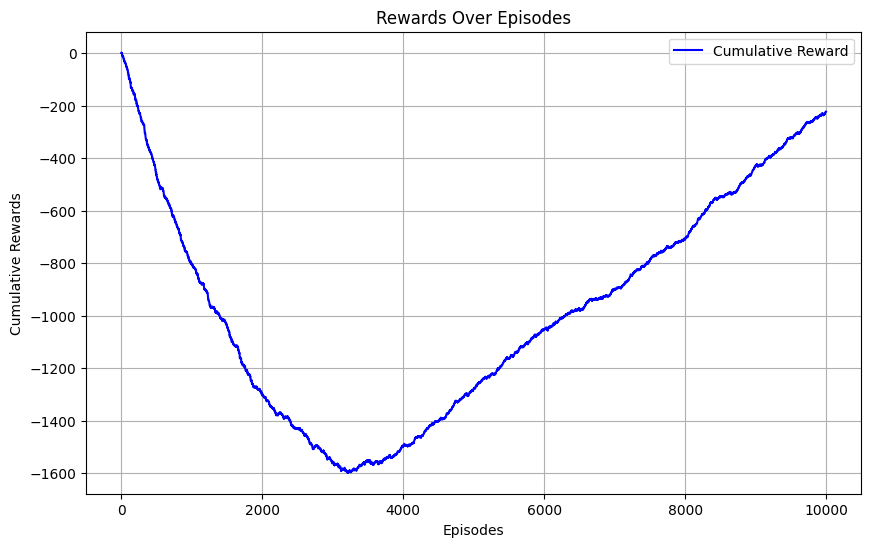

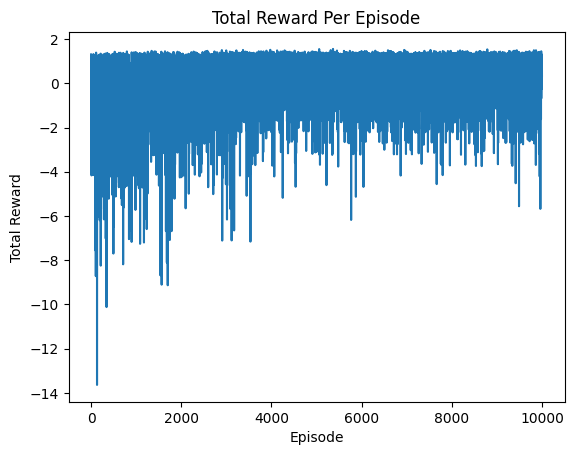

In [18]:
import matplotlib.pyplot as plt
import numpy as np

#Rewards over Episodes
plt.figure(figsize=(10,6))
plt.plot(range(n_episodes), cumulative_rewards, label="Cumulative Reward", color="blue")
plt.xlabel("Episodes")
plt.ylabel("Cumulative Rewards")
plt.title("Rewards Over Episodes")
plt.legend()
plt.grid(True)
plt.show()

#Total Rewards Per Episodes
plt.plot(range(len(episode_rewards)), episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward Per Episode')
plt.show()

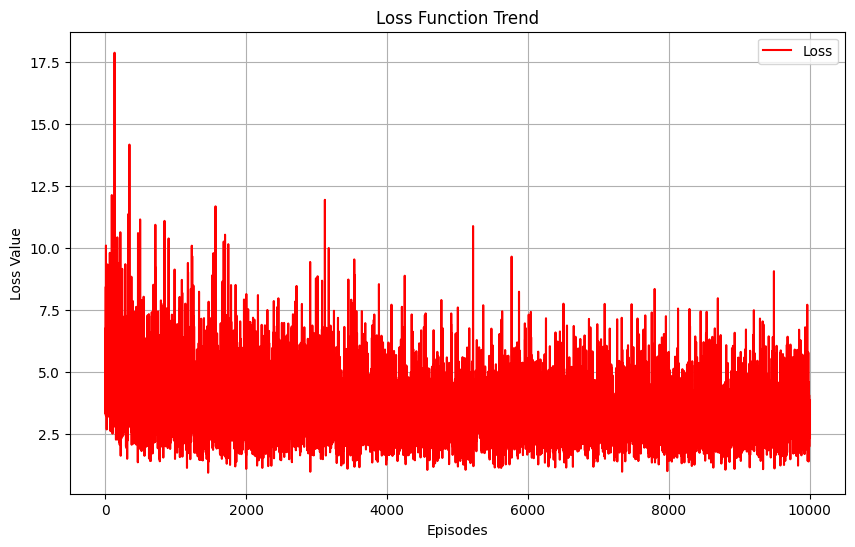

In [19]:
#Loss function trend

plt.figure(figsize=(10,6))
plt.plot(range(n_episodes), episode_losses, label="Loss", color="red")
plt.xlabel("Episodes")
plt.ylabel("Loss Value")
plt.title("Loss Function Trend")
plt.legend()
plt.grid(True)
plt.show()

C:\Users\matth\AppData\Local\Temp\ipykernel_12260\1745218691.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


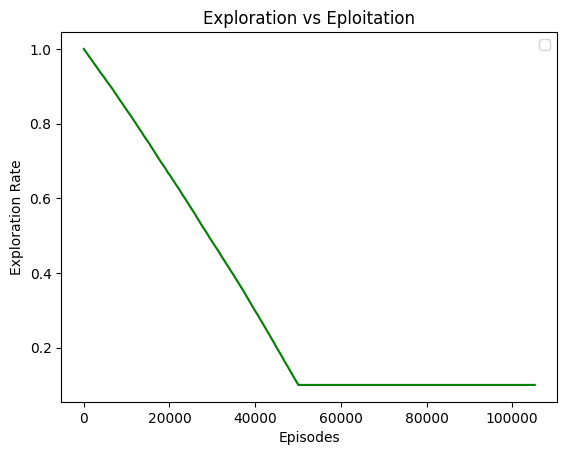

In [20]:
#Exploration vs exploitation

plt.plot(epsilon_values, color="green")
plt.xlabel("Episodes")
plt.ylabel("Exploration Rate")
plt.title("Exploration vs Eploitation")
plt.legend()
plt.show()

In [ ]:
#Closes the environments once completed
nim.close()
display.close()